In [86]:
import pandas as pd
import folium
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import os
import requests, io


UsageError: Line magic function `%` not found.


In [87]:
%matplotlib inline

In [2]:
CLIENT_ID = os.environ.get('FOURSQUARE_ID')
CLIENT_SECRET = os.environ.get('FOURSQUARE_SECRET')

VERSION = '20180605' # Foursquare API version
LIMIT = 100

In [3]:
london_codes_all = pd.read_csv('London postcodes.csv')

In [4]:
london_codes_all.head(5)

,Postcode,In Use?,Latitude,Longitude,Easting,Northing,Grid Ref,County,District,Ward,...,User Type,Last updated,Nearest station,Distance to station,Postcode area,Postcode district,Police force,Water company,Plus Code,Average Income
0,BR1 1AA,Yes,51.401546,0.015415,540291,168873,TQ402688,Greater London,Bromley,Bromley Town,...,0,2020-02-19,Bromley South,0.218257,BR,BR1,Metropolitan Police,Thames Water,9F32C228+J5,63100
1,BR1 1AB,Yes,51.406333,0.015208,540262,169405,TQ402694,Greater London,Bromley,Bromley Town,...,0,2020-02-19,Bromley North,0.253666,BR,BR1,Metropolitan Police,Thames Water,9F32C248+G3,56100
2,BR1 1AD,No,51.400057,0.016715,540386,168710,TQ403687,Greater London,Bromley,Bromley Town,...,1,2020-02-19,Bromley South,0.044559,BR,BR1,Metropolitan Police,NaN,9F32C228+2M,63100
3,BR1 1AE,Yes,51.404543,0.014195,540197,169204,TQ401692,Greater London,Bromley,Bromley Town,...,0,2020-02-19,Bromley North,0.462939,BR,BR1,Metropolitan Police,Thames Water,9F32C237+RM,63100
4,BR1 1AF,Yes,51.401392,0.014948,540259,168855,TQ402688,Greater London,Bromley,Bromley Town,...,0,2020-02-19,Bromley South,0.227664,BR,BR1,Metropolitan Police,Thames Water,9F32C227+HX,63100


In [5]:
london_relevant_columns = london_codes_all[['District','Ward', 'Constituency', 'Postcode district', 'Postcode', 'Latitude', 'Longitude']]

In [6]:
london_relevant_columns.head()

,District,Ward,Constituency,Postcode district,Postcode,Latitude,Longitude
0,Bromley,Bromley Town,Bromley and Chislehurst,BR1,BR1 1AA,51.401546,0.015415
1,Bromley,Bromley Town,Bromley and Chislehurst,BR1,BR1 1AB,51.406333,0.015208
2,Bromley,Bromley Town,Bromley and Chislehurst,BR1,BR1 1AD,51.400057,0.016715
3,Bromley,Bromley Town,Bromley and Chislehurst,BR1,BR1 1AE,51.404543,0.014195
4,Bromley,Bromley Town,Bromley and Chislehurst,BR1,BR1 1AF,51.401392,0.014948


In [7]:
london_relevant_columns.shape

(321834, 7)

In [8]:
consituencies = london_relevant_columns.groupby('Constituency').agg('mean').reset_index()

In [9]:
consituencies

,Constituency,Latitude,Longitude
0,Barking,51.540223,0.108926
1,Battersea,51.467693,-0.156828
2,Beckenham,51.392635,-0.010579
3,Bermondsey and Old Southwark,51.495689,-0.079441
4,Bethnal Green and Bow,51.524791,-0.054384
5,Bexleyheath and Crayford,51.463503,0.154297
6,Brent Central,51.547856,-0.249144
7,Brent North,51.563430,-0.294205
8,Brentford and Isleworth,51.479030,-0.316095
9,Bromley and Chislehurst,51.408920,0.037758


In [10]:
latitude = 51.5074
longitude = -0.1278

In [11]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, consituency in zip(consituencies['Latitude'], consituencies['Longitude'], consituencies['Constituency']):
    label = '{}'.format(consituency)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

In [259]:
districts = london_relevant_columns.groupby('Postcode district').agg('mean').reset_index()

In [268]:
# Residential london only
districts = districts[
    (districts['Postcode district'].str[0]=='E') 
    | (districts['Postcode district'].str[0]=='N')
    | (districts['Postcode district'].str[0]=='S')
    | (districts['Postcode district'].str[0]=='W')
]
districts = districts[
    (districts['Postcode district'].str[0:2]!='EN')
    & (districts['Postcode district'].str[0:2]!='SM')
    & (districts['Postcode district'].str[0:2]!='WD')
    & (districts['Postcode district'].str[0:2]!='WC')
    & (districts['Postcode district'].str[0:2]!='W1')
    & (districts['Postcode district'].str[0:2]!='EC')
    & (districts['Postcode district'].str[0:3]!='SW1')
]

In [269]:
districts.head()

,Postcode district,Latitude,Longitude
32,E1,51.516257,-0.060423
33,E10,51.568702,-0.012773
34,E11,51.567375,0.011668
35,E12,51.551033,0.050806
36,E13,51.528216,0.025794


In [270]:
map_london_code = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, district in zip(districts['Latitude'], districts['Longitude'], districts['Postcode district']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london_code)  
    
map_london_code

### Use foursquare to get local venues

In [271]:
CLIENT_ID = os.environ.get('FOURSQUARE_ID')
CLIENT_SECRET = os.environ.get('FOURSQUARE_SECRET')

VERSION = '20180605' # Foursquare API version
LIMIT = 500

In [272]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [273]:
london_venues_raw = getNearbyVenues(names=districts['Postcode district'],
                                   latitudes=districts['Latitude'],
                                   longitudes=districts['Longitude']
                                  )

E1
E10
E11
E12
E13
E14
E15
E16
E17
E18
E1W
E2
E20
E3
E4
E5
E6
E7
E77
E8
E9
E98
N1
N10
N11
N12
N13
N14
N15
N16
N17
N18
N19
N1C
N1P
N2
N20
N21
N22
N3
N4
N5
N6
N7
N8
N81
N9
NW1
NW10
NW11
NW1W
NW2
NW26
NW3
NW4
NW5
NW6
NW7
NW8
NW9
SE1
SE10
SE11
SE12
SE13
SE14
SE15
SE16
SE17
SE18
SE19
SE1P
SE2
SE20
SE21
SE22
SE23
SE24
SE25
SE26
SE27
SE28
SE3
SE4
SE5
SE6
SE7
SE8
SE9
SE99
SW2
SW20
SW3
SW4
SW5
SW6
SW7
SW8
SW9
SW95
SW99
W2
W3
W4
W5
W6
W7
W8
W9


In [274]:
london_venues1 = london_venues_raw.copy()
london_venues1.shape

(3291, 7)

In [275]:
london_venues1[london_venues1['Neighborhood']=='E1']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,E1,51.516257,-0.060423,Lahore One,51.514725,-0.059399,Indian Restaurant
1,E1,51.516257,-0.060423,Lahore Kebab House,51.514483,-0.062912,Kebab Restaurant
2,E1,51.516257,-0.060423,New Road Hotel,51.517575,-0.062658,Hotel
3,E1,51.516257,-0.060423,Needoo Grill,51.517070,-0.062379,Indian Restaurant
4,E1,51.516257,-0.060423,Mouse Tail Coffee Stories,51.519471,-0.058573,Coffee Shop
5,E1,51.516257,-0.060423,Tayyabs,51.517240,-0.063476,North Indian Restaurant
6,E1,51.516257,-0.060423,Qbic Hotel,51.516183,-0.067454,Hotel
7,E1,51.516257,-0.060423,The Crêpe Shop,51.517224,-0.062888,Creperie
8,E1,51.516257,-0.060423,Zaza's,51.518066,-0.064340,Indian Restaurant
9,E1,51.516257,-0.060423,More Yoga Aldgate,51.515574,-0.067395,Yoga Studio


In [296]:
london2 = london_venues1[
    (london_venues1['Neighborhood'].str[0]=='E') 
    | (london_venues1['Neighborhood'].str[0]=='N')
    | (london_venues1['Neighborhood'].str[0]=='S')
    | (london_venues1['Neighborhood'].str[0]=='W')
]
london_filter = london2[
    (london_venues1['Neighborhood'].str[0:2]!='EN')
    & (london_venues1['Neighborhood'].str[0:2]!='SM')
    & (london_venues1['Neighborhood'].str[0:2]!='WD')
    & (london_venues1['Neighborhood'].str[0:2]!='WC')
    & (london_venues1['Neighborhood'].str[0:2]!='EC')
]

In [297]:
london_filter['Neighborhood'].unique()

array(['E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17',
       'E18', 'E1W', 'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E77',
       'E8', 'E9', 'E98', 'N1', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15',
       'N16', 'N17', 'N18', 'N19', 'N1C', 'N1P', 'N2', 'N20', 'N21',
       'N22', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N81', 'N9', 'NW1',
       'NW10', 'NW11', 'NW1W', 'NW2', 'NW26', 'NW3', 'NW4', 'NW5', 'NW6',
       'NW7', 'NW8', 'NW9', 'SE1', 'SE10', 'SE11', 'SE12', 'SE13', 'SE14',
       'SE15', 'SE16', 'SE17', 'SE18', 'SE19', 'SE1P', 'SE2', 'SE20',
       'SE21', 'SE22', 'SE23', 'SE24', 'SE25', 'SE26', 'SE27', 'SE28',
       'SE3', 'SE4', 'SE5', 'SE6', 'SE7', 'SE8', 'SE9', 'SE99', 'SW2',
       'SW20', 'SW3', 'SW4', 'SW5', 'SW6', 'SW7', 'SW8', 'SW9', 'SW95',
       'SW99', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9'],
      dtype=object)

In [298]:
london_venues = london_filter.copy()

In [299]:
# london_venues[london_venues['Neighborhood']=='BR2']

In [300]:
london_venues['Venue Category'].value_counts().head()

Pub                   261
Café                  208
Coffee Shop           198
Grocery Store         134
Italian Restaurant     93
Name: Venue Category, dtype: int64

In [301]:
london_venues.Venue.value_counts().head()

Costa Coffee         43
Subway               28
Tesco Express        25
Sainsbury's Local    24
Co-op Food           22
Name: Venue, dtype: int64

In [302]:
# london_venues['Venue Category'] = london_venues['Venue']

### one hot encoding

In [303]:
london_one_hot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

In [304]:
london_one_hot.shape

(3291, 273)

In [305]:
london_one_hot['Postcode district'] = london_venues['Neighborhood']

In [306]:
london_one_hot.shape

(3291, 274)

In [307]:
# london_one_hot.to_csv('london_one_hot.csv')

In [308]:
london_grouped = london_one_hot.groupby('Postcode district').mean().reset_index()
london_grouped.shape

(109, 274)

In [309]:
# london_grouped[london_grouped['Postcode district']=='BR2'].to_csv('br2.csv')

In [310]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [311]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postcode district']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Postcode district'] = london_grouped['Postcode district']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)


In [312]:
neighborhoods_venues_sorted.head()

,Postcode district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,E1,Hotel,Grocery Store,Indian Restaurant,Pub,Coffee Shop,Sandwich Place,Bakery,Gym / Fitness Center,Yoga Studio,English Restaurant
1,E10,Park,Convenience Store,Coffee Shop,Farm,Train Station,Asian Restaurant,Cricket Ground,Hotel,Dessert Shop,Ethiopian Restaurant
2,E11,Café,Pub,Grocery Store,Fast Food Restaurant,Coffee Shop,Platform,Pizza Place,Dim Sum Restaurant,Music Venue,Metro Station
3,E12,Train Station,Restaurant,Gym / Fitness Center,Yoga Studio,Fabric Shop,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
4,E13,Pub,Café,Bus Station,Gym,Yoga Studio,Farm,Event Space,Exhibit,Fabric Shop,Falafel Restaurant


(array([ 6., 59.,  1.,  1.,  1.,  2.,  1.,  1., 37.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

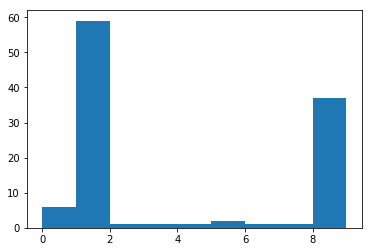

In [313]:
# set number of clusters
kclusters = 10

london_grouped_clustering = london_grouped.drop('Postcode district', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
plt.hist(kmeans.labels_, bins=range(kclusters))

(array([21., 19.,  5., 64.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

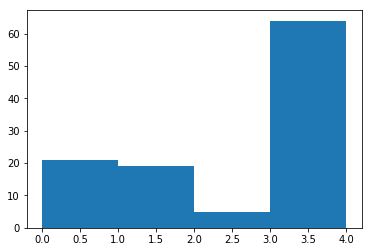

In [316]:
# set number of clusters
kclusters = 5

london_grouped_clustering = london_grouped.drop('Postcode district', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
plt.hist(kmeans.labels_, bins=range(kclusters))

(array([ 1.,  3.,  1.,  1., 18.,  4.,  1.,  1.,  1.,  1., 35.,  1.,  1.,
         1.,  1.,  3.,  9., 14.,  4.,  8.]),
 array([ 0.  ,  0.95,  1.9 ,  2.85,  3.8 ,  4.75,  5.7 ,  6.65,  7.6 ,
         8.55,  9.5 , 10.45, 11.4 , 12.35, 13.3 , 14.25, 15.2 , 16.15,
        17.1 , 18.05, 19.  ]),
 <a list of 20 Patch objects>)

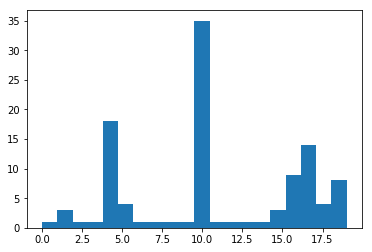

In [315]:
# set number of clusters
kclusters = 20

london_grouped_clustering = london_grouped.drop('Postcode district', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
plt.hist(kmeans.labels_, bins=kclusters)

In [317]:
len(kmeans.labels_)

109

In [318]:
labels = kmeans.labels_
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', labels)

In [319]:
neighborhoods_venues_sorted.shape

(109, 12)

In [320]:
london_data = districts.copy()

london_merged = london_data.merge(neighborhoods_venues_sorted, on='Postcode district')

In [321]:
london_merged.head()

,Postcode district,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,E1,51.516257,-0.060423,4,Hotel,Grocery Store,Indian Restaurant,Pub,Coffee Shop,Sandwich Place,Bakery,Gym / Fitness Center,Yoga Studio,English Restaurant
1,E10,51.568702,-0.012773,0,Park,Convenience Store,Coffee Shop,Farm,Train Station,Asian Restaurant,Cricket Ground,Hotel,Dessert Shop,Ethiopian Restaurant
2,E11,51.567375,0.011668,4,Café,Pub,Grocery Store,Fast Food Restaurant,Coffee Shop,Platform,Pizza Place,Dim Sum Restaurant,Music Venue,Metro Station
3,E12,51.551033,0.050806,4,Train Station,Restaurant,Gym / Fitness Center,Yoga Studio,Fabric Shop,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
4,E13,51.528216,0.025794,1,Pub,Café,Bus Station,Gym,Yoga Studio,Farm,Event Space,Exhibit,Fabric Shop,Falafel Restaurant


### Map of london clusters

In [322]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Postcode district'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [323]:
london_merged.shape[1]

14

In [324]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,Postcode district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,E10,Park,Convenience Store,Coffee Shop,Farm,Train Station,Asian Restaurant,Cricket Ground,Hotel,Dessert Shop,Ethiopian Restaurant
10,E1W,Grocery Store,Fast Food Restaurant,Park,Coffee Shop,Gym / Fitness Center,Event Space,Dive Bar,Sandwich Place,Bar,Bakery
15,E5,Grocery Store,Pub,Business Service,Turkish Restaurant,Beer Bar,Bus Stop,Liquor Store,Cocktail Bar,Coffee Shop,Garden
17,E7,Grocery Store,Pub,Bus Stop,Market,Café,Comfort Food Restaurant,Train Station,Fast Food Restaurant,Bakery,Indian Restaurant
24,N11,Grocery Store,Fish & Chips Shop,Hardware Store,Beer Bar,Furniture / Home Store,Toy / Game Store,Train Station,Scenic Lookout,Shopping Plaza,Bus Stop
26,N13,Coffee Shop,Grocery Store,Pub,Pizza Place,Italian Restaurant,Mediterranean Restaurant,Breakfast Spot,Sandwich Place,Bakery,Thrift / Vintage Store
32,N19,Bus Stop,Coffee Shop,Grocery Store,Pizza Place,Pub,Sandwich Place,Italian Restaurant,Café,Farmers Market,Kebab Restaurant
37,N21,Italian Restaurant,Pub,Middle Eastern Restaurant,Supermarket,Grocery Store,Coffee Shop,Bistro,Bar,Bus Stop,Farmers Market
52,NW26,Bar,Coffee Shop,Tapas Restaurant,Restaurant,Bakery,Lebanese Restaurant,Italian Restaurant,Park,Modern European Restaurant,Hotel
61,SE10,Pub,Grocery Store,Pier,Bar,Turkish Restaurant,Indian Restaurant,Beach,College Cafeteria,Scenic Lookout,Japanese Restaurant


In [325]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,Postcode district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,E13,Pub,Café,Bus Station,Gym,Yoga Studio,Farm,Event Space,Exhibit,Fabric Shop,Falafel Restaurant
13,E3,Pub,Grocery Store,Bar,Bus Stop,Locksmith,Light Rail Station,Burger Joint,Convenience Store,Dim Sum Restaurant,Fabric Shop
19,E8,Pub,Yoga Studio,Park,Café,Lounge,Seafood Restaurant,Boutique,Bookstore,Restaurant,Donut Shop
20,E9,Pub,Café,Coffee Shop,Yoga Studio,Garden,Beer Store,Gastropub,Dumpling Restaurant,Park,Bakery
22,N1,Pub,Burger Joint,Park,Bakery,Theater,Mediterranean Restaurant,Café,Restaurant,Road,Bookstore
29,N16,Café,Pub,Gift Shop,Italian Restaurant,Cocktail Bar,Fruit & Vegetable Store,Nightclub,Beer Store,Gastropub,South Indian Restaurant
30,N17,Pub,Supermarket,Gym / Fitness Center,Roller Rink,Sandwich Place,Grocery Store,Train Station,Italian Restaurant,Gas Station,Bar
34,N1P,Pub,Boutique,Burger Joint,French Restaurant,Cocktail Bar,Park,Mediterranean Restaurant,Ice Cream Shop,Hotel,Gastropub
40,N4,Outdoor Gym,Pub,Park,Athletics & Sports,Café,Farmers Market,Hotel,Filipino Restaurant,Fast Food Restaurant,Film Studio
42,N6,Pub,Pizza Place,Japanese Restaurant,Park,Café,Seafood Restaurant,French Restaurant,Tea Room,Jazz Club,Trail


In [326]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,Postcode district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,E6,Grocery Store,Park,Gym / Fitness Center,Yoga Studio,Falafel Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Farm
28,N15,Hostel,Park,Grocery Store,Café,Yoga Studio,Falafel Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop
57,NW7,Construction & Landscaping,Park,Yoga Studio,Farm,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market
63,SE12,Laundromat,Soccer Field,Park,Yoga Studio,Farm,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market
89,SE99,Grocery Store,Gay Bar,Café,Art Gallery,Yoga Studio,Farm,Event Space,Exhibit,Fabric Shop,Falafel Restaurant


In [327]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,Postcode district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,E4,Pub,Yoga Studio,Farmers Market,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Fast Food Restaurant


In [328]:
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,Postcode district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,E1,Hotel,Grocery Store,Indian Restaurant,Pub,Coffee Shop,Sandwich Place,Bakery,Gym / Fitness Center,Yoga Studio,English Restaurant
2,E11,Café,Pub,Grocery Store,Fast Food Restaurant,Coffee Shop,Platform,Pizza Place,Dim Sum Restaurant,Music Venue,Metro Station
3,E12,Train Station,Restaurant,Gym / Fitness Center,Yoga Studio,Fabric Shop,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
5,E14,Coffee Shop,Park,Café,Indian Restaurant,Burger Joint,Plaza,Italian Restaurant,Gym / Fitness Center,Sushi Restaurant,Pizza Place
6,E15,Pub,Coffee Shop,Café,Hotel,Sandwich Place,Fast Food Restaurant,Pharmacy,Bar,General Entertainment,Platform
7,E16,Hotel,Café,Chinese Restaurant,Pub,Train Station,Scenic Lookout,Steakhouse,Tapas Restaurant,Coffee Shop,Japanese Restaurant
8,E17,Coffee Shop,Grocery Store,Pub,Sandwich Place,Pizza Place,Bakery,Café,Pharmacy,Clothing Store,Bookstore
9,E18,Italian Restaurant,Grocery Store,Bar,Coffee Shop,Supermarket,Yoga Studio,Pizza Place,Dessert Shop,Portuguese Restaurant,Pub
11,E2,Coffee Shop,Pub,Cocktail Bar,Café,Hotel,Italian Restaurant,Pizza Place,Gym / Fitness Center,Bar,Flower Shop
12,E20,Clothing Store,Café,Coffee Shop,Ice Cream Shop,Italian Restaurant,Burger Joint,Pub,Pizza Place,Toy / Game Store,Laser Tag


In [329]:
london_merged.loc[london_merged['Cluster Labels'] == 5, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,Postcode district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [ ]:
url = 'http://api.zoopla.co.uk/api/v1/average_sold_prices'